In [2]:
# Import the class from the Python file (module)
import pandas as pd
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
from pathlib import Path
from sklearn.preprocessing import StandardScaler

from BinanceClient import BinanceClient
%matplotlib widget

In [3]:
# Initialize Binance client with your API credentials
dotenv_path = Path('.env-secret')
load_dotenv(dotenv_path=dotenv_path)
api_secret = os.getenv("BINANCE_SECRET_KEY")
api_key = os.getenv("BINANCE_API_KEY")

# Create Binance client
binance_client = BinanceClient(api_key, api_secret)


In [4]:
fetch_data_from_binance = False
# Define trading pair and date range
pair = "BTCUSDT"
start_date = "01 Jan, 2024"
end_date = "01 Dec, 2024"


if fetch_data_from_binance:
    # Fetch data
    data = binance_client.fetch_data(pair, start_date, end_date)
    binance_client.store_data_to_db(pair, data)
else:
    data = binance_client.fetch_data_from_db(pair, start_date, end_date)
      

#### Create dataframe 

In [5]:
  
# Check if data is fetched
if not data.empty:
    # Convert the fetched data into a pandas DataFrame
    df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
    
    # Convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    
    # Set the timestamp as the index
    df.set_index('timestamp', inplace=True)
    
    # Convert the columns to numeric (some values may be strings by default)
    df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].apply(pd.to_numeric)

else:
    print("No data found!!!.")

In [6]:
# Check for missing data
# Compute differences in minutes between consecutive timestamps
time_diffs = df.index.to_series().diff().dt.total_seconds() / 60

# If everything is perfect, all intervals should be ~5 minutes
missing_intervals = time_diffs[time_diffs > 5]

if not missing_intervals.empty:
    print("Missing data found... Kindly fix it!!")
else:
    print("No missing data found")


No missing data found


In [7]:
# Drop Nan Columns
df.dropna(axis=1, inplace=True)


#### Feature Engineering

In [8]:
# Simple Moving Average (SMA)
df['sma_10'] = df['close'].rolling(window=10).mean()
df['sma_50'] = df['close'].rolling(window=50).mean()

# Exponential Moving Average (EMA)
df['ema_10'] = df['close'].ewm(span=10, adjust=False).mean()

# Relative Strength Index (RSI)
delta = df['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['rsi_14'] = 100 - (100 / (1 + rs))

# Moving Average Convergence Divergence (MACD)
ema_12 = df['close'].ewm(span=12, adjust=False).mean()
ema_26 = df['close'].ewm(span=26, adjust=False).mean()
df['macd'] = ema_12 - ema_26
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
df['macd_hist'] = df['macd'] - df['macd_signal']

# Volatility Indicators

# Bollinger Bands
sma_20 = df['close'].rolling(window=20).mean()
std_20 = df['close'].rolling(window=20).std()
df['bollinger_upper'] = sma_20 + (2 * std_20)
df['bollinger_lower'] = sma_20 - (2 * std_20)

# Average True Range (ATR)
high_low = df['high'] - df['low']
high_prev_close = (df['high'] - df['close'].shift()).abs()
low_prev_close = (df['low'] - df['close'].shift()).abs()
true_range = high_low.to_frame('hl').join(high_prev_close.to_frame('hpc')).join(low_prev_close.to_frame('lpc')).max(axis=1)
df['atr_14'] = true_range.rolling(window=14).mean()

# Volume-Based Features
df['volume_ma_20'] = df['volume'].rolling(window=20).mean()
df['volume_ratio'] = df['volume'] / df['volume_ma_20']

# Derived Features

# Rate of Change (ROC)
df['roc_10'] = (df['close'] - df['close'].shift(10)) / df['close'].shift(10) * 100

# Lagged Features
df['close_lag_1'] = df['close'].shift(1)
df['close_lag_3'] = df['close'].shift(3)
df['macd_lag_1'] = df['close'].shift(1)

# Candle Features
df['candle_body'] = df['close'] - df['open']
df['upper_wick'] = df['high'] - df[['close', 'open']].max(axis=1)
df['lower_wick'] = df[['close', 'open']].min(axis=1) - df['low']


#### Define Targets

In [11]:
# Predict the price change over the next 5 candles
df['target'] = (df['close'].shift(-5) - df['close']) / df['close'] * 100

#### Feature Scaling

In [ ]:
# Drop NaNs
df_clean = df.dropna()  # Drop all rows with NaNs

# df is sorted by time and indexed by a datetime index
n = len(df)
train_end = int(n * 0.8) # 80% data used for training
train_df = df_clean.iloc[:train_end]
test_df = df_clean.iloc[train_end:]

# Separate features and target
X_train = train_df.drop('target', axis=1)
y_train = train_df['target']
# define a threshold for "positive" class; we want to buy when thre is 50% rise expected
threshold = 0.05
y_train_class = (y_train > threshold).astype(int)

X_test = test_df.drop('target', axis=1)
y_test = test_df['target']
y_test_class = (y_test > threshold).astype(int)

# Scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [104]:
from sklearn.linear_model import LogisticRegression

# model = LogisticRegression(class_weight='balanced')
model = LogisticRegression()
model.fit(X_train_scaled, y_train_class)

LogisticRegression()

In [115]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train_scaled, y_train_class)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [109]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'sma_10', 'sma_50', 'ema_10',
       'rsi_14', 'macd', 'macd_signal', 'macd_hist', 'bollinger_upper',
       'bollinger_lower', 'atr_14', 'volume_ma_20', 'volume_ratio', 'roc_10',
       'close_lag_1', 'close_lag_3', 'macd_lag_1', 'candle_body', 'upper_wick',
       'lower_wick', 'target'],
      dtype='object')

In [116]:
# Make Prediction
y_pred = model.predict(X_test_scaled)

# Convert to pandas series
y_pred_series = pd.Series(y_pred, index=X_test.index, name='prediction')


#### Train the model

#### Perfoamce Evaluation

In [117]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Accuracy:", accuracy_score(y_test_class, y_pred_series))
print("Confusion Matrix:\n", confusion_matrix(y_test_class, y_pred_series))
print("Classification Report:\n", classification_report(y_test_class, y_pred_series))


Accuracy: 0.9462326452082575
Confusion Matrix:
 [[18173    63]
 [  971    24]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97     18236
           1       0.28      0.02      0.04       995

    accuracy                           0.95     19231
   macro avg       0.61      0.51      0.51     19231
weighted avg       0.91      0.95      0.92     19231



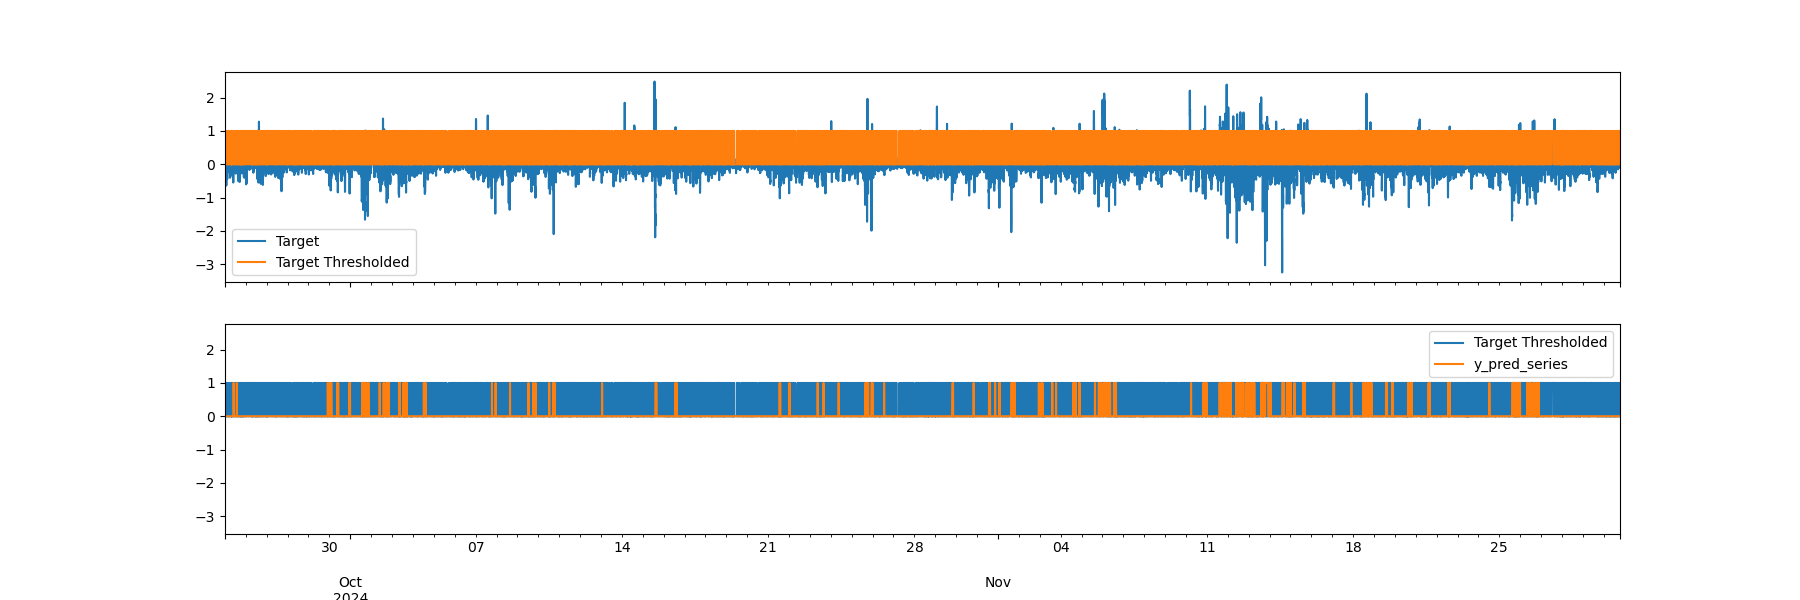

In [107]:
plt.close('all')
# Create subplots with shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12), sharex=True, sharey=True)

y_test.plot(ax=ax1, figsize=[18, 6], label='Target', legend=True)
y_test_class.plot(ax=ax1, figsize=[18, 6], label='Target Thresholded', legend=True)

y_test_class.plot(ax=ax2, figsize=[18, 6], label='Target Thresholded', legend=True)
y_pred_series.plot(ax=ax2, figsize=[18, 6], label='y_pred_series', legend=True)
plt.show()

In [ ]:

plt.clf()
# Plot the closing price
df['close']['2024-11-01':].plot(figsize=(18, 6), title=f'{pair} Close Price', xlabel='Date', ylabel='Price (USDT)')
df['bollinger_upper']['2024-11-01':].plot(figsize=(18, 6), title=f'{pair} bollinger_upper', xlabel='Date', ylabel='Price (USDT)')
df['bollinger_lower']['2024-11-01':].plot(figsize=(18, 6), title=f'{pair} bollinger_upper', xlabel='Date', ylabel='Price (USDT)')
# df['macd']['2024-11-01':].plot(figsize=(18, 6), title=f'{pair} bollinger_upper', xlabel='Date', ylabel='Price (USDT)')
plt.show() 
